# Sampling our video snippets to pick random frames

Now, we have our list_file ready to access our videos. We will use segmental strategy to pick random number of frames in each segment.
For example, say we have 160 frames per some video and we chose number of segments to be 5, so we have 160/5=32. We have 32 frames per each segment. 

We will pick one frame per segment meaning that we will have 5 random frames extracted from the whole video. This reduces the computational cost as the number of frames is reduced. 

Note: Increasing number of segments leads to increase of the accuracy. (num_segments = 7 is the best for speed/accuracy)

First, we import some important libraries.

In [5]:
import torch.utils.data as data                         #PyTorch library to use our dataset class as a subclass of torch dataset.
from PIL import Image                                     #Library to let us interact with different images.
import os                                                          #library to interact with your OS whether it is Windows, Linux or MAC                                                 
import numpy as np                                         #numpy library for linear algebra and matrices operations
from numpy.random import randint                #for random number generator                   

Let's build our first class for extracting our required data from our list_file.

Note: @property function is used, so we can overwrite the path, num_frames or label for any given data. It also simplifies the call of a function instead of writing it as obj.path(). It can be called easily with obj.path.

In [7]:
class Video_Info(object):
    '''
      line: Vidoes info imported form list_file [Directory -- # of frames -- label]
    '''
    def __init__(self, line):
        self.data = line
        
    @property  
    def path(self):
        return self.data[0]

    @property
    def num_frames(self):
        return int(self.data[1])

    @property
    def label(self):
        return int(self.data[2])

Then, we build our TSNDataset class which is a subclass of torch dataset.

In [8]:
class TSNDataset(data.Dataset):
    '''
    file_list         : FileList.txt 
    num_segments      : Default = 3
    new_length        : The num of sequentially picked from the frames (1 'RGB' , 2 with 'RGBDiff')
    modality          : Takes two strings 'RGB' or 'RGBDiff'
    image_prefix      : Prefix of the frames name
    transform         : Pytorch composion of transformations (Data Augmentation)
    train_val_switch : True for train and False for validation

    The overall use of this class is :
    >>TestObj = TSNdataset(......)                    #Creating an object
    >>TestObj[Index]                                  #Index : is the index for a video in the dataset (0:13320)
    '''
    def __init__(self, file_list,num_segments=3, new_length=1, modality='RGB',
                 image_prefix='frame{:06d}.jpg', transform=None, test_mode=False, train_val_switch=True):

        #self.root_path = root_path                                   #not used, yet
        self.file_list = file_list
        self.num_segments = num_segments
        self.new_length = new_length
        self.modality = modality
        self.image_prefix = image_prefix
        self.transform = transform
        self.test_mode = test_mode
        self.train_val_switch = train_val_switch                                      

        #List of Objects, Everyone of them corresponding to a video
        self.VidInfoList = [Video_Info(x.strip().split('  '))  for x in open(self.file_list)]
    
  
    def Train_Sample_indices(self,info):
        '''
        info: Object has info about one video
        This function determine the indices for the chosen frames
        '''
        if info.num_frames < self.num_segments:
            return np.zeros((self.num_segments,))                                             #Return the same frames in a given segment

        FPSeg = info.num_frames // self.num_segments                                            #Frames per segment
        offset = [x*FPSeg for x in range(self.num_segments)]                                             #The first index for every segment 
        frame_indices = list(randint(FPSeg,size=self.num_segments))                                 #Chosen frames form every segment
        sample_indices = [sum(i) for i in zip(frame_indices,offset)]                                #elment-wise sumtion of offset and smaple_indices
        return np.array(sample_indices)+1                                                           #Frames indices starts from 000001
  
  
    def Val_Sample_indices(self,info):
        '''
        info : Object has info about one video
        This function determine the indices for the chosen frames
        '''
        if info.num_frames < self.num_segments:
            return np.zeros((self.num_segments,))

        FPSeg = info.num_frames / float(self.num_segments)
        sample_indices = [int(FPSeg*( x + 1/2.0 )) for x in range(self.num_segments)]               #Get the middle frame for every segment
        return np.array(sample_indices)+1
  
  
    def Test_Sample_indices(self,info):
        '''
        info : Object has info about one video
        This function determine the indices for the chosen frames
        '''    
        if info.num_frames < self.num_segments:
            return np.zeros((self.num_segments,))

        FPSeg = info.num_frames / float(self.num_segments)
        sample_indices = [int(FPSeg*( x + 1/2.0 )) for x in range(self.num_segments)]
        return np.array(sample_indices)+1
    
    
    def Vid2Frames(self, info, indices):
        '''
        info : Object has info about one video
        indices  : Indices for the chosen frames
        '''
        images = []
        for idx in indices:                                                          #For every frame in the chosen frames
            Img = [Image.open(os.path.join(info.path,self.image_prefix.format(idx))).convert('RGB')]                 #Load the frame and convert to PNG
            images.extend(Img)                                                        #Stack it with the others

        #processed_frames = self.transform(images)                                   #Apply transform stuff on the chosen frames
        return images, info.path, info.num_frames, info.label                                  
  
  
    def __getitem__(self,idx):
        '''
        idx : Index for a video into the dataset
        The main perpuse of this function is to interact 'nicer' with the object of the class
        >>TestObj[3] 
        This line output a tuple (List of chosen frames,label) for the 3rd video in the dataset
        '''
        vid_info = self.VidInfoList[idx]
        if self.test_mode:
            indices = self.Test_Sample_indices(vid_info)
        else:
            indices = self.Train_Sample_indices(vid_info) if self.train_val_switch else self.Val_Sample_indices(vid_info)
        return self.Vid2Frames(vid_info, indices), indices
    
    def __len__(self):
        return len(self.VidInfoList)

  

Now, let's try our class and see if it outputs the correct frames.

In [9]:
UCF = TSNDataset(file_list=r'C:\Driver E\Jimy\Machine_Learning\Graduation_Project\UCF_Dataset\rgb_train_FileList1.txt',
                 num_segments=7, new_length=1, modality='RGB', image_prefix='frame{:06d}.jpg',
                 transform=None,test_mode=False ,train_val_switch=True)



In [20]:
video_details, indices =UCF[8000]   #the first video for example 

In [23]:
video_details

([<PIL.Image.Image image mode=RGB size=342x256 at 0x22DDEAA6A58>,
  <PIL.Image.Image image mode=RGB size=342x256 at 0x22DDEAA6BA8>,
  <PIL.Image.Image image mode=RGB size=342x256 at 0x22DDEAA6BE0>,
  <PIL.Image.Image image mode=RGB size=342x256 at 0x22DDEAA6C50>,
  <PIL.Image.Image image mode=RGB size=342x256 at 0x22DDEAA6CC0>,
  <PIL.Image.Image image mode=RGB size=342x256 at 0x22DDEAA6D30>,
  <PIL.Image.Image image mode=RGB size=342x256 at 0x22DDEAA6DA0>],
 'C:\\Driver E\\Jimy\\Machine_Learning\\Graduation_Project\\UCF_Dataset\\jpegs_256\\v_SoccerPenalty_g08_c04',
 169,
 84)

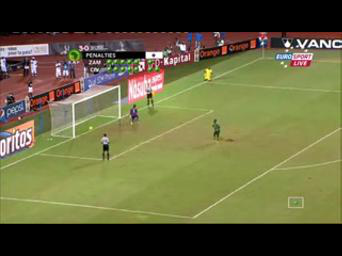

In [25]:
video_details[0][6]

In [24]:
indices

array([  6,  34,  67,  93, 100, 133, 166])

Here, we got the details of a selected video and the indices generated by selecting random frames in each segment.